In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

## GRADER PLEASE NOTE

* Some of the instructions are different from the original but still adhere to the rubric.
* The students get the average precipitation per day instead of every single precipitation value.

In [9]:
# Find the most recent date in the data set.
session.query(func.count(Measurement.date)).all()

[(19550)]

In [10]:
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

In [11]:
# Using this date, find the average precipitation per day
# for the preceding 12 months of data sorted by ascending date.
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
months_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
months_ago

datetime.date(2016, 8, 23)

In [14]:
prcp_avg = engine.execute("SELECT date, prcp FROM measurement WHERE date >= '2016-08-23'\
                          ORDER BY date ASC").fetchall()
# prcp_avg

In [15]:
# Convert your results into a pandas DataFrame with date as index.
df_prcp = pd.DataFrame(prcp_avg)
df_prcp1 = df_prcp.rename(columns={0:"Date", 1:"Precipitation"})

In [16]:
grouped_df_prcp = df_prcp1.groupby("Date")["Precipitation"].agg([np.mean])
grouped_df_prcp1 = grouped_df_prcp.rename(columns={"mean": "Precipitation"})
grouped_df_prcp1

,Precipitation
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


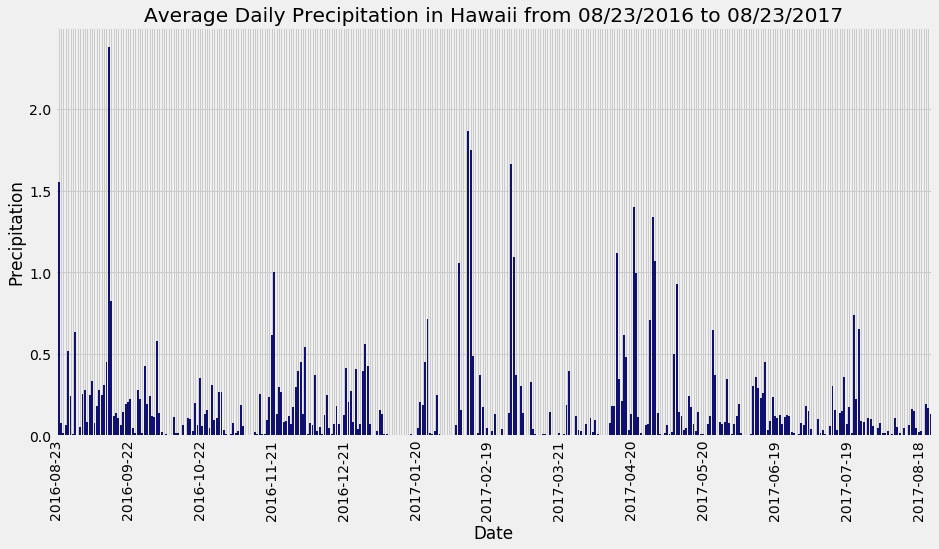

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
import seaborn as sns
plt.figure(figsize=(14,7))
plot = sns.barplot(x=grouped_df_prcp1.index, y=grouped_df_prcp1.Precipitation, color="navy")
for i, j in enumerate(plot.get_xticklabels()):
    if i % 30 == 0:
        j.set_visible(True)
    else:
        j.set_visible(False)
plt.xticks(rotation=90)
plt.grid(True)
plt.title("Average Daily Precipitation in Hawaii from 08/23/2016 to 08/23/2017")
plt.show()

In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
grouped_df_prcp1.describe()

,Precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [27]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [37]:
# Query total number of stations in dataset
stations = engine.execute("SELECT COUNT(station) FROM station").fetchall()
num_of_stations = stations[0][0]
print(f"There are {num_of_stations} stations")

There are 9 stations


In [38]:
# Verifying number of stations using measurement data
stations = engine.execute("SELECT COUNT(DISTINCT station) FROM measurement").fetchall()
num_of_stations = stations[0][0]
num_of_stations

9

In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = engine.execute("SELECT station, COUNT(*) AS 'counts'\
                                 FROM measurement GROUP BY station\
                                 ORDER BY counts DESC").fetchall()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [51]:
active_stations_id = active_stations[0][0]
print(f"{active_stations_id} is the most active station")

USC00519281 is the most active station


In [73]:
# Using the station id from the previous query, calculate the lowest, 
# highest, and average temperature recorded for this station.
sum_stats = engine.execute("SELECT MIN(tobs), MAX(tobs), AVG(tobs) \
                           FROM measurement WHERE station = 'USC00519281'").fetchall()
df = pd.DataFrame(sum_stats, index=["USC00519281"])
sum_stats_df = df.rename(columns={0: "Min Temp", 1: "Max Temp", 2: "Avg Temp"})
sum_stats_df

,Min Temp,Max Temp,Avg Temp
USC00519281,54.0,85.0,71.663781


In [80]:
# Query the last 12 months of temperature observation data for this station.
# Plot the results as a histogram with bins = 12.
temp = engine.execute("SELECT tobs FROM measurement \
                      WHERE station = 'USC00519281' \
                      AND date >= '2016-08-23'").fetchall()
df_1 = pd.DataFrame(temp)
temp_df = df_1.rename(columns={0: "Temperature"})
temp_df

,Temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


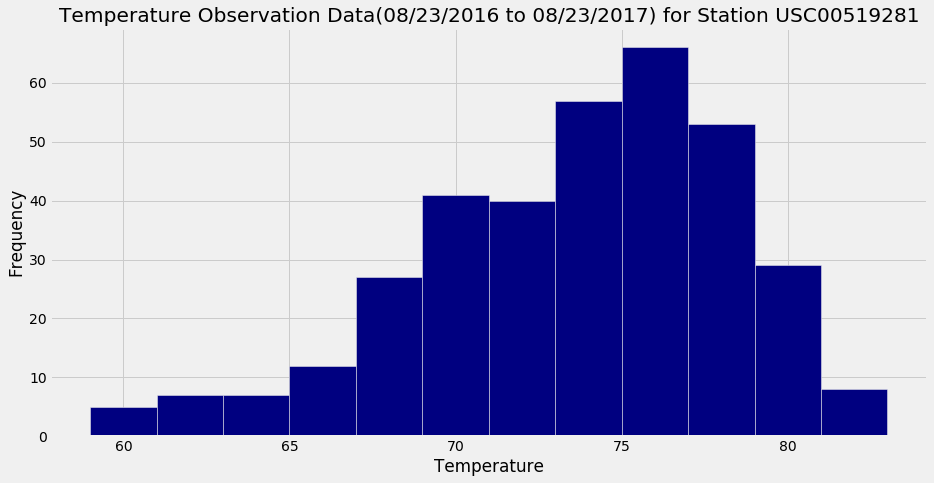

In [84]:
plt.figure(figsize=(14,7))
plt.title("Temperature Observation Data(08/23/2016 to 08/23/2017) for Station USC00519281")
plt.ylabel("Frequency")
sns.histplot(data = temp_df["Temperature"], color="navy", alpha=1, bins=12)
plt.show()

# Close session

In [86]:
session.close()